# Exercice1

In [380]:
import torch
import torch.nn.functional as F
import functorch
import matplotlib.pyplot as plt
#loading the data
train_data = torch.load('train_data.pt')
test_data = torch.load('test_data.pt')
valid_data = torch.load('valid_data.pt')
vocab = torch.load('vocab.pt')
print(vocab)
print(test_data[0])
print(test_data[3])

{0: 'all', 1: 'set', 2: 'just', 3: 'show', 4: 'being', 5: 'money', 6: 'over', 7: 'both', 8: 'years', 9: 'four', 10: 'through', 11: 'during', 12: 'go', 13: 'still', 14: 'children', 15: 'before', 16: 'police', 17: 'office', 18: 'million', 19: 'also', 20: 'less', 21: 'had', 22: ',', 23: 'including', 24: 'should', 25: 'to', 26: 'only', 27: 'going', 28: 'under', 29: 'has', 30: 'might', 31: 'do', 32: 'them', 33: 'good', 34: 'around', 35: 'get', 36: 'very', 37: 'big', 38: 'dr.', 39: 'game', 40: 'every', 41: 'know', 42: 'they', 43: 'not', 44: 'world', 45: 'now', 46: 'him', 47: 'school', 48: 'several', 49: 'like', 50: 'did', 51: 'university', 52: 'companies', 53: 'these', 54: 'she', 55: 'team', 56: 'found', 57: 'where', 58: 'right', 59: 'says', 60: 'people', 61: 'house', 62: 'national', 63: 'some', 64: 'back', 65: 'see', 66: 'street', 67: 'are', 68: 'year', 69: 'home', 70: 'best', 71: 'out', 72: 'even', 73: 'what', 74: 'said', 75: 'for', 76: 'federal', 77: 'since', 78: 'its', 79: 'may', 80: 'st

In [355]:
def word_from_idx(index):
    if index in vocab:
        return vocab[index]
    else:
        return "<UNK>"
def idx_from_word(word):
    index = [k for k in vocab.keys() if vocab[k]==word ]
    return index[0]
            


In [356]:
print("=== premiers grams dans test-data ===")
for i in range(5):
    list = []
    for j in range(4):
        index = test_data[i][j].item()
        list.append(word_from_idx(index))
        list_to_pint = " ".join(list)
    print(list_to_pint)
print("=== premiers grams dans train-data ===")   
for i in range(5):
    list = []
    for j in range(4):
        index = train_data[i][j].item()
        list.append(word_from_idx(index))
        list_to_pint = " ".join(list)
    print(list_to_pint)
print("=== premiers grams dans valid-data ===")   
for i in range(5):
    list = []
    for j in range(4):
        index = valid_data[i][j].item()
        list.append(word_from_idx(index))
        list_to_pint = " ".join(list)
    print(list_to_pint)    

=== premiers grams dans test-data ===
can be called .
they are well ,
are well , she
well , she said
, she said .
=== premiers grams dans train-data ===
going to be .
were not the first
can do for each
first time in my
nt have the money
=== premiers grams dans valid-data ===
he would have been
would have been right
have been right there
been right there .
i did nt even


# Exercice 2

In [357]:
from torch.utils.data import Dataset, DataLoader

class MyDataSet(Dataset):
    def __init__(self, inputs, targets):
        # device agnostic code:
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")
        print(device)
        self.inputs = inputs.to(device)
        self.targets = targets.to(device)     
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]

train_loader = DataLoader(MyDataSet(train_data[:,:3], train_data[:,3]), batch_size=400)
validation_loader = DataLoader(MyDataSet(valid_data[:,:3], valid_data[:,3]), batch_size=400)
test_loader = DataLoader(MyDataSet(train_data[:,:3], train_data[:,3]), batch_size=400)

cpu
cpu
cpu


# Exercice 3

In [358]:
class WordModule(torch.nn.Module):
    def __init__(self, n_words, d_context, d_dist_repr, d_hidden):
        super().__init__()
        self.d_context = d_context
        self.d_dist_repr= d_dist_repr
        
        self.embed = torch.nn.Embedding(n_words, d_dist_repr) # fait le 1 hot encoding en plus d'associer des vecteurs aux mots
        self.hidden = torch.nn.Linear(d_context * d_dist_repr, d_hidden)
        self.act1 = torch.nn.ReLU()
        self.outLayer = torch.nn.Linear(d_hidden, n_words)
        self.act2 = torch.nn.LogSoftmax(dim=1)  
        
    def forward(self, x):
        x = self.embed(x)
        x = self.hidden(x.view(-1, self.d_context * self.d_dist_repr))
        x = self.act1(x)               
        x = self.act2(self.outLayer(x))
        return x
        

n_words = len(vocab) #nombre total de mots dans le vocabulaire
d_context = 3 # nombre de features 
d_dist_repr = 64 # dimension de la couche d'immersion
d_hidden = 128 # dimension de la couche cachée
model = WordModule( n_words,d_context,d_dist_repr,d_hidden)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params = count_parameters(model)
print("Nombre total de paramètres du modèle :", num_params)

Nombre total de paramètres du modèle : 72954


In [359]:
# Activer le mode évaluation du modèle
model.eval()

for i in range(10):
   
    indices = train_data[i][:3]
    input_features = [word_from_idx(indices[j].item()) for j in range(3)]
    input_features_str = " ".join(input_features)
    # faire une prédiction avec le modèle
    with torch.no_grad():
        output = model(indices)
        
    pred_idx = torch.argmax(output, dim=1).item()
    pred_word = word_from_idx(pred_idx)
    
    # Afficher les features et la prédiction du modèle
    print(f"FEATURES: {input_features_str}")
    print(f"MODEL PREDICTION: {pred_word}")


FEATURES: going to be
MODEL PREDICTION: might
FEATURES: were not the
MODEL PREDICTION: down
FEATURES: can do for
MODEL PREDICTION: because
FEATURES: first time in
MODEL PREDICTION: i
FEATURES: nt have the
MODEL PREDICTION: after
FEATURES: know what to
MODEL PREDICTION: a
FEATURES: i do nt
MODEL PREDICTION: because
FEATURES: nt do that
MODEL PREDICTION: we
FEATURES: what do you
MODEL PREDICTION: he
FEATURES: know is we
MODEL PREDICTION: play


## Exercice 4

/tmp/ipykernel_1146627/4010851145.py:4: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::isin.Tensor_Tensor. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  good_predictions = functorch.vmap(lambda t1, t2: torch.isin(t1,t2))(targets, tensor_top)


Loss at epoch 0: 5.551830291748047 accuracy 3.0 number of batch 0
Loss at epoch 100: 3.180391788482666 accuracy 66.25 number of batch 100
Loss at epoch 200: 3.1318631172180176 accuracy 67.25 number of batch 200
Loss at epoch 300: 3.0665831565856934 accuracy 73.25 number of batch 300
Loss at epoch 400: 2.924107551574707 accuracy 72.5 number of batch 0
Loss at epoch 500: 3.0302157402038574 accuracy 72.75 number of batch 100
Loss at epoch 600: 2.8876540660858154 accuracy 73.5 number of batch 200
Loss at epoch 700: 2.801271677017212 accuracy 76.75 number of batch 300
Loss at epoch 800: 2.9323432445526123 accuracy 73.75 number of batch 0
Loss at epoch 900: 2.874803066253662 accuracy 73.5 number of batch 100
Loss at epoch 1000: 2.646587610244751 accuracy 79.75 number of batch 200
Loss at epoch 1100: 2.7089433670043945 accuracy 77.0 number of batch 300
Loss at epoch 1200: 2.880645990371704 accuracy 75.25 number of batch 0
Loss at epoch 1300: 2.8205301761627197 accuracy 76.75 number of batch 1

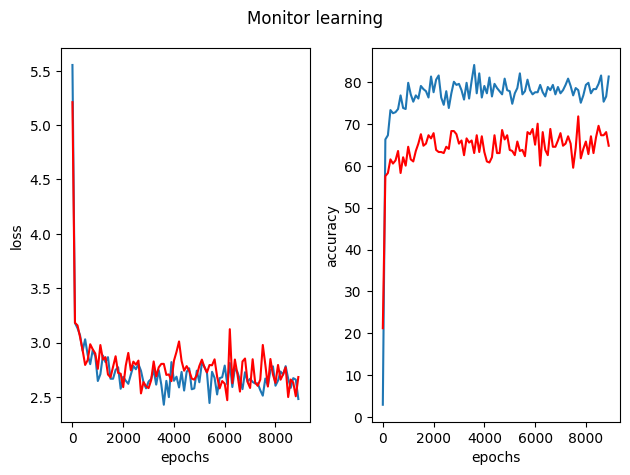

In [360]:
def accuracy(predictions_proba, targets, top=5):
    tensor_top = torch.topk(predictions_proba, top).indices
    # warning, not yet efficiently implemented
    good_predictions = functorch.vmap(lambda t1, t2: torch.isin(t1,t2))(targets, tensor_top)
    return (good_predictions).sum()/len(targets) * 100

# Plot monitoring
def ith(l, i):
    return [x[i] for x in l]

def plot_history(h):
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(ith(h,0), ith(h,1))
    axs[0].plot(ith(h,0), ith(h,3), color='red')
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('loss')
    axs[1].plot(ith(h,0), ith(h,2))
    axs[1].plot(ith(h,0), ith(h,4), color='red')
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('accuracy')
    fig.suptitle('Monitor learning')
    fig.tight_layout()
    plt.show()

    
def grad_des(epoch, model, optim):
    history = []
    train_inputs= []
    train_target = []
    validation_inputs = []
    validation_labels = []
    
    for inputs, targets in validation_loader:
        validation_inputs.append(inputs)
        validation_labels.append(targets)
        
        
    for inputs_, guesses_ in train_loader:
            train_inputs.append(inputs_)
            train_target.append(guesses_)
            
    for ep in range(epoch):       
        pred = model(train_inputs[ep%len(train_inputs)])
        
        err = F.nll_loss(pred, train_target[ep%len(train_target)])
        model.zero_grad()
        err.backward()
        optim.step()

        if ep % 100 == 0:
                
            acc = accuracy(pred, train_target[ep%len(train_target)],10)
            acc_val = accuracy( model(validation_inputs[ep%len(validation_inputs)]), validation_labels[ep%len(validation_labels)],5)
            pred = model(validation_inputs[ep%len(validation_inputs)])
            loss_val =  F.nll_loss(pred, validation_labels[ep%len(validation_labels)])
            history.append((ep, err.detach().numpy(), acc, loss_val.detach().numpy(), acc_val))
            print(f"Loss at epoch {ep}: {err.item()} accuracy {acc} number of batch {ep%train_loader.batch_size}")
    
    return history
    

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
history= grad_des(9000, model, optimizer)
plot_history(history)


## Exercice 5

In [381]:
def predict_next_word(context, model):
    with torch.no_grad():
        output = model(context)
        predicted_id = torch.argmax(output, dim=1).item()
        predicted_word = word_from_idx(predicted_id)
    return predicted_word

context = torch.tensor([182,  89, 186])
context2 = torch.tensor([242,  22,  54])
input_features = [word_from_idx(id.item()) for id in context]
input_features_str = " ".join(input_features)
print(f"Context words : {input_features_str}")
predicted_word = predict_next_word(context, model)
print("Predicted last word:", predicted_word)
input_features = [word_from_idx(id.item()) for id in context2]
input_features_str = " ".join(input_features)
print(f"Context words : {input_features_str}")
predicted_word = predict_next_word(context2, model)
print("Predicted last word:", predicted_word)


Context words : can be called
Predicted last word: .
Context words : well , she
Predicted last word: said


In [382]:
def word_distance(w1, w2, model):
    id1 =  idx_from_word(w1)
    id2 =  idx_from_word(w2)
    w1_emb = model.embed.weight[id1]
    w2_emb = model.embed.weight[id2]
    distance = torch.dist(w1_emb, w2_emb)
    
    return distance.item()

distance = word_distance("yesterday", ".", model)  
print(distance)

10.70667552947998


In [363]:
distance = word_distance("to", "to", model)  
print(distance)

0.0


#### la distance respresente la distance euclidienne entre les embeddings des mots(la relation entre eux), plus les mots sont similaires(presque meme context) plus la distance est petite et invesrsement.

In [390]:
def display_nearest_words(w, model, top):
    distances = []
    for word in vocab.values():
        if word != w:
            distance = word_distance(w, word, model)
            distances.append((word, distance))
    
    # sorting
    distances.sort(key=lambda x: x[1])
    
    # Affichage des mots les plus proches
    print(f"Les {top} mots les plus proches de '{w}':")
    for i in range(top):
        print(f"{i+1}. {distances[i][0]} (distance: {distances[i][1]})")

# Exemple d'utilisation
display_nearest_words("when", model, 3)


Les 3 mots les plus proches de 'when':
1. what (distance: 4.131457805633545)
2. how (distance: 4.181199550628662)
3. where (distance: 4.2130913734436035)
